# Data Processing

The following demonstrates how to use PaperDoll raw dataset combined with ModaNet annotations.

In [1]:
import io
import lmdb
import sqlite3
import pandas as pd
from PIL import Image
from IPython.display import display

## Photo data in LMDB

The following is a convenient wrapper over LMDB.

In [2]:
class PhotoData(object):
    def __init__(self, path):
        self.env = lmdb.open(
            path, map_size=2**36, readonly=True, lock=False
        )
        
    def __iter__(self):
        with self.env.begin() as t:
            with t.cursor() as c:
                for key, value in c:
                    yield key, value
        
    def __getitem__(self, index):
        key = str(index).encode('ascii')
        with self.env.begin() as t:
            data = t.get(key)
        if not data:
            return None
        with io.BytesIO(data) as f:
            image = Image.open(f)
            image.load()
            return image
        
    def __len__(self):
        return self.env.stat()['entries']

In [3]:
photo_data = PhotoData('./photos.lmdb')
print(len(photo_data))

1097474


In [4]:
import json

json_file = 'modanet2018_instances_train.json'
d = json.load(open(json_file))
print(d.keys(), len(d['images']))

dict_keys(['info', 'images', 'year', 'licenses', 'type', 'annotations', 'categories']) 52377


In [5]:
print(d['images'][0])
for i in range(5):
    print(d['images'][i]['id'], end=" ")
print(len(d['annotations']))

{'file_name': '0736791.jpg', 'width': 400, 'id': 736791, 'license': 3, 'height': 600}
736791 997730 763229 764244 1019370 265705


In [6]:
df_ann = pd.DataFrame(d['annotations']).set_index(['image_id', 'id'])
df_ann.head()

area                  bbox  category_id  iscrowd  \
image_id id                                                      
736791   0    1746    [160, 247, 97, 18]            2        0   
         1    1260    [287, 537, 30, 42]            4        0   
         2    1092    [287, 537, 26, 42]            4        0   
         3   37352  [132, 255, 161, 232]           11        0   
         4   14605  [145, 126, 115, 127]            9        0   

                                                  segmentation  
image_id id                                                     
736791   0   [[161, 248, 170, 248, 173, 249, 189, 251, 199,...  
         1   [[198, 543, 197, 551, 198, 556, 199, 565, 200,...  
         2   [[289, 554, 287, 564, 287, 573, 287, 577, 292,...  
         3   [[147, 281, 141, 288, 136, 297, 132, 304, 132,...  
         4   [[159, 131, 162, 150, 162, 167, 159, 176, 150,...

In [7]:
from pycocotools.coco import COCO
coco=COCO(json_file)
coco.imgs[736791]

loading annotations into memory...
Done (t=4.08s)
creating index...
index created!


{'file_name': '0736791.jpg',
 'width': 400,
 'id': 736791,
 'license': 3,
 'height': 600}

In [9]:
cats = coco.loadCats(coco.getCatIds())
all_ctgs = [cat['name'] for cat in cats]
print(all_ctgs)

all_ctg_ids = coco.getCatIds(catNms=all_ctgs)
all_ctg_ids

['bag', 'belt', 'boots', 'footwear', 'outer', 'dress', 'sunglasses', 'pants', 'top', 'shorts', 'skirt', 'headwear', 'scarf/tie']


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [11]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


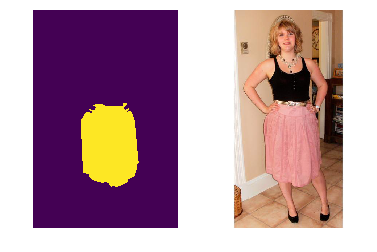

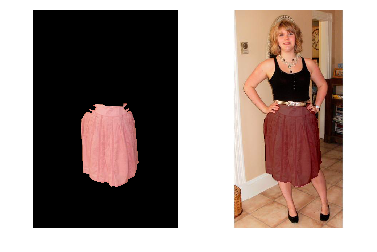

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
import pylab
import numpy as np

img_id = 736791

# print(all_ctg_ids) #catIds = all_ctg_ids,9,4,2,11
annIds = coco.getAnnIds(imgIds=img_id, catIds=11, iscrowd=None)
anns = coco.loadAnns(annIds)

# coco.showAnns(anns)
mask = coco.annToMask(anns[0])
for i in range(len(anns)):
    mask += coco.annToMask(anns[i])

    image = photo_data[img_id]
# out = np.array(image.getdata()).astype(np.int32).reshape((image.size[1], image.size[0], 3))
out = np.array(image, np.int32)
# mask out skirt
other = out * (mask[:,:,None] == 0)
skirt = out * (mask[:,:,None]!=0)
change = (out-100) * (mask[:,:,None]!=0)
mix = other + skirt

plt.figure(1)
plt.subplot(1,2,1).axis('off')
plt.imshow(mask)
plt.subplot(1,2,2).axis('off')
plt.imshow(mix)

plt.figure(2)
plt.subplot(1,2,1).axis('off')
plt.imshow(skirt)
plt.subplot(1,2,2).axis('off')
plt.imshow(other+change)